In [1]:
%matplotlib inline
from os import listdir
from os.path import isfile, join
import numpy as np
from glob import glob
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib
import statsmodels.stats.multitest as smt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from matplotlib.colors import DivergingNorm

/Users/osipova/local/Homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


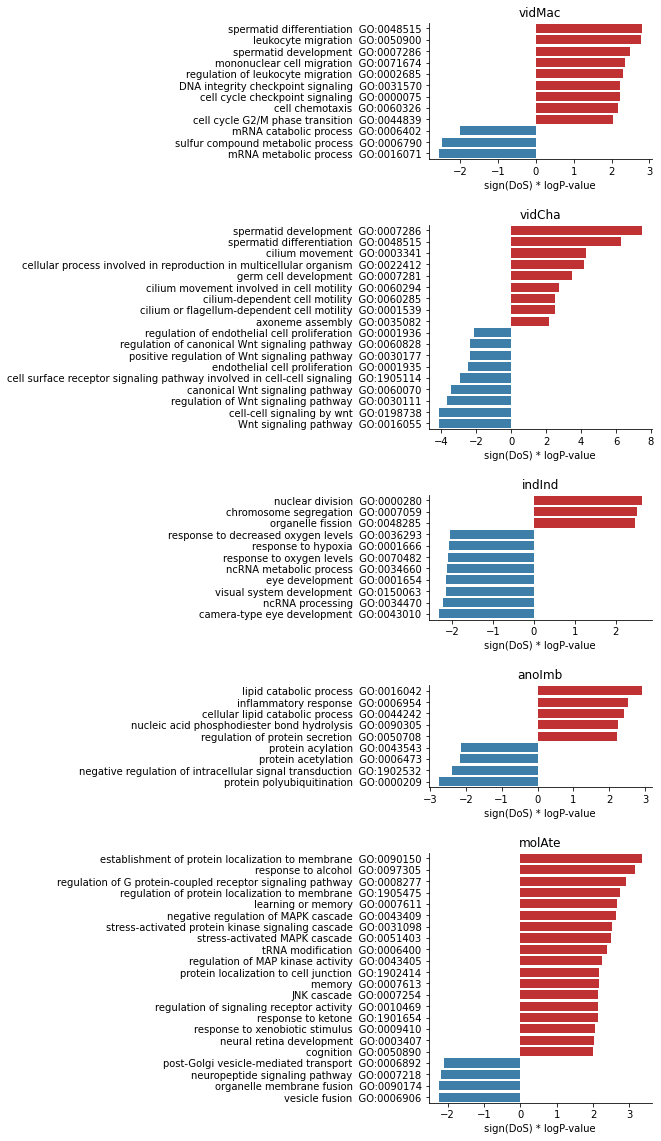

In [4]:
## GSEA from clusterProfiler
dir_path = '/Users/osipova/Documents/LabDocs/Brood_parasites_analysis/'
dbs = ['vidMac', 'vidCha', 'indInd', 'anoImb', 'molAte']

## Load data
DF_dbs = {}
for db in dbs:
    file_name = 'MK_test_{}_ncbi/gse.tsv'.format(db)
    file_data = glob(dir_path + file_name)[0]
    df = pd.read_csv(file_data, sep='\t')

    df['GOfull'] = df['Description'] + '  ' + df['ID']
    df['logpval'] = - np.log10(df['pvalue'])
    dos = [1 if x > 0 else -1 for x in df['NES']]
    df['dos'] = dos
    df['sign_logP'] = df['logpval'] * dos
    df.sort_values(by=['sign_logP'], inplace=True, ascending=False)
    DF_dbs[db] = df


## Plot barplots p-value DoS > 0 and DoS < 0
db_ratios = [DF_dbs[db].shape[0] for db in dbs]

fig, axes = plt.subplots(len(dbs), 1, gridspec_kw={'height_ratios': db_ratios}, figsize=(4, 5*len(dbs)))

i = 0
for db in dbs:
    axi = axes[i]
    sns.set_palette(['#2b83ba', '#d7191c'])
    df = DF_dbs[db]
    sns.barplot(ax=axi, data=df, x='sign_logP', y='GOfull', hue='dos', dodge=False)
    axi.set(xlabel='sign(DoS) * logP-value', ylabel='')
    axi.legend([], [], frameon=False)
    axi.set_title(db)
    i += 1
    
sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.subplots_adjust(bottom=0, top=0.6, wspace=0, hspace=0.4)
fig.tight_layout()  

# pdf_name = 'gsea_top_terms.4clades.clusterProfiler.pdf'.format(db)
pdf_name = 'gsea_top_terms.5clades.clusterProfiler.pdf'.format(db)
# fig.savefig(pdf_name, bbox_inches='tight')

/Users/osipova/local/Homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
/Users/osipova/local/Homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


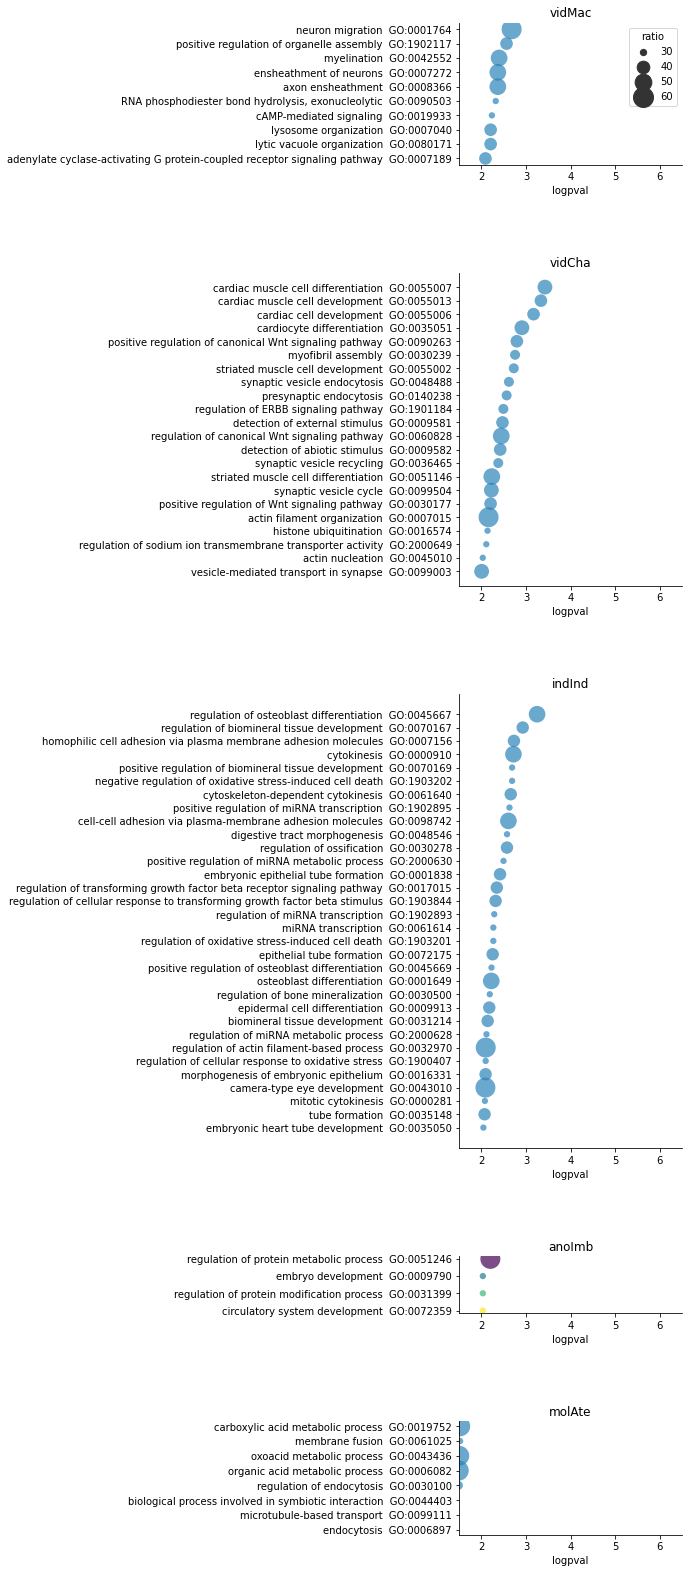

In [6]:
## GO Enrichment from clusterProfiler
dir_path = '/Users/osipova/Documents/LabDocs/Brood_parasites_analysis/'
dbs = ['vidMac', 'vidCha', 'indInd', 'anoImb', 'molAte']

## DoS > 0 or < 0?
# dos = 'pos'
dos = 'neg'


## Load data
DF_dbs = {}
for db in dbs:
    file_name = 'MK_test_{}_ncbi/{}.enrichGO.tsv'.format(db, dos)
    file_data = glob(dir_path + file_name)[0]
    df = pd.read_csv(file_data, sep='\t')

    df['GOfull'] = df['Description'] + '  ' + df['ID']
    df['logpval'] = - np.log10(df['pvalue'])
    df['ngenes'], df['nset'] = df['GeneRatio'].str.split('/').str
    df['ratio'] = (pd.to_numeric(df['ngenes']) / pd.to_numeric(df['nset']) * 1000).astype(int)
    DF_dbs[db] = df
    

## Plot barplots p-value DoS > 0 and DoS < 0
db_ratios = [DF_dbs[db].shape[0] for db in dbs]
fig, axes = plt.subplots(len(dbs), 1, gridspec_kw={'height_ratios': db_ratios}, figsize=(4, 7*len(dbs)))

blue = '#2b83ba'
red = '#d7191c'
if dos == 'pos':
    c = red
elif dos == 'neg':
    c = blue

i = 0
for db in dbs:
    axi = axes[i]
    dfi = DF_dbs[db]
    sns.scatterplot(ax=axi, data=dfi, x='logpval', y='GOfull', size='ratio', sizes=(40, 400),
                    color=c, alpha=0.7, linewidth=0)
    axi.set(xlim=(1.5, 6.5), ylabel='')
    axi.set_title(db)
    if i != 0:
        axi.legend([], [], frameon=False)
    i += 1
    
sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False) 
fig.subplots_adjust(bottom=0, top=0.6, wspace=0, hspace=0.5)
fig.tight_layout()

# pdf_name = '{}.enrichGO.4clades.clusterProfiler.pdf'.format(dos)
pdf_name = '{}.enrichGO.5clades.clusterProfiler.pdf'.format(dos)
fig.savefig(pdf_name, bbox_inches='tight')

/Users/osipova/local/Homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  if sys.path[0] == '':
/Users/osipova/local/Homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


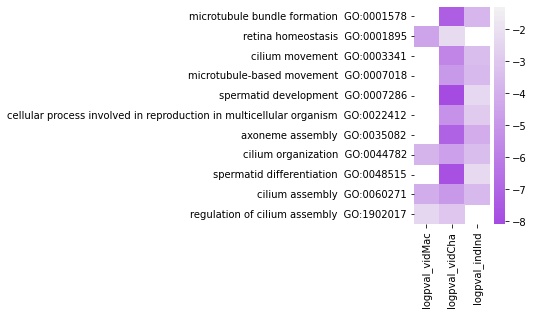

In [99]:
### Make a heatmap for convergent terms

file_name = 'go_convergent_2clades.tsv'
file_data = glob(dir_path + file_name)[0]
df = pd.read_csv(file_data, sep='\t')
df.set_index('Description', inplace=True)

for pval_col in pval_cols:
    df['log'+pval_col] = np.log10(df[pval_col])

cmap = sns.diverging_palette(285, 200, 80, as_cmap=True)
divnorm_pval = DivergingNorm(vmax=0, vcenter=np.log10(0.051))

logpval_cols = [i for i in df.columns if i.startswith('logpval')]
df_pval = df[logpval_cols]

fig, axes = plt.subplots(figsize=(1.7, 4))
sns.heatmap(data=df_pval, cmap=cmap, norm=divnorm)
axes.set_ylabel('')
fig.tight_layout()

pdf_name = 'convergence.pos.goEnrich.2_and_more_clades.p0.1.pdf'

# plt.savefig(pdf_name, format='pdf', bbox_inches="tight")